In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

import sys
sys.path.append('/home/code/mlflow')
import models.Preprocessing as pre
import models.utils as ut
from keras.models import load_model

#RF用のimport　上のGRUのimportは後で消す
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

data_path = '/home/code/data/processed/week_dataset.csv'
df = pd.read_csv(data_path)

model_path1 = '/home/code/mlflow/experiments/GRU_experiment/4月4日_GRUモデル/1week/gru_best_model_gru512_dense1024_loss0.0045.h5'
model_path2 = '/home/code/mlflow/experiments/GRU_experiment/4月4日_GRUモデル/2week/gru_best_model_gru256_dense1024_loss0.0040.h5'
model_path3 = '/home/code/mlflow/experiments/GRU_experiment/4月4日_GRUモデル/3week/gru_best_model_gru512_dense1024_loss0.0043.h5'

feature_path1 = '/home/code/mlflow/experiments/GRU_experiment/4月4日_GRUモデル/1week/GRU_features.csv'
feature_path2 = '/home/code/mlflow/experiments/GRU_experiment/4月4日_GRUモデル/2week/GRU_features.csv'
feature_path3 = '/home/code/mlflow/experiments/GRU_experiment/4月4日_GRUモデル/3week/GRU_features.csv'

# 前処理用のパラメータ設定
week_1 = 7
week_2 = 14
week_3 = 21

weekly_mean_columns = ['Week Shipment']
weekly_total_columns = ['Status', 'Temp']
shift_unchange_name_columns = ['Status', 'Week Status', 'Week Shipment Mean', 'Week Status2', 'Target2']
shift_change_name_columns = ['Temp', 'Week Temp']
env_columns1 = ['Temp-'+str(week_1), 'Week Temp-'+str(week_1)]
env_columns2 = ['Temp-'+str(week_2), 'Week Temp-'+str(week_2)]
env_columns3 = ['Temp-'+str(week_3), 'Week Temp-'+str(week_3)]

cat_columns = ['Week Number']
drop_columns = ['Target', 'Week', 'Week Start', 'Week End', 'Week Status2', 'Teisyoku', 
                'Week Teisyoku', 'Week WNDDIR','Week WNDSPD', 'Week RHUM', 'Week PRCRIN_30MIN', 
                'Week SNWFLL_30MIN', 'Week WX', 'Week Solar', 'Week Rain', 'Week Pred Temp',
                'WNDDIR', 'WNDSPD', 'RHUM', 'PRCRIN_30MIN', 'SNWFLL_30MIN', 'WX', 'Solar', 'Rain',
                'Pred Temp', 'GLBRAD', 'GLBRAD_30MIN', 'Week GLBRAD', 'Week GLBRAD_30MIN',
                'AIRTMP', 'Week AIRTMP']

df_week1 = df.copy()
df_week2 = df.copy()
df_week3 = df.copy()

df_week1 = (
        df_week1.pipe(pre.change_column_name)
        .pipe(pre.set_index_date)
        .pipe(pre.add_status)
        .pipe(pre.add_weekday)
        .pipe(pre.fill_temp)
        .pipe(pre.add_weekly_total, columns=weekly_total_columns)
        .pipe(pre.add_weekly_mean, columns=weekly_mean_columns) 
        .pipe(pre.add_week_status2)
        .pipe(pre.add_target2, target_days=week_1) # Week Shipmentをズラす前に作成することに注意
        .pipe(pre.shift_unchange_name, shift_columns=shift_unchange_name_columns, shift_days=week_1)
        .pipe(pre.shift_change_name, shift_columns=shift_change_name_columns, shift_days=[week_1])
        .pipe(pre.add_target, target_days=week_1) # Week Shipmentをズラす前に作成することに注意
        .pipe(pre.shift_unchange_name, shift_columns=['Week Shipment'], shift_days=-7) # Week Shipmentは1週間前のデータを使用
        .pipe(pre.drop_columns, drop_columns=drop_columns)
        .pipe(pre.categorize_columns, cat_columns=cat_columns)
        .pipe(pre.load_feature_columns, feature_path=feature_path1)
        .pipe(pre.fill_week_status)
        .pipe(pre.normalize_columns2, feature_path=feature_path1)
        .pipe(pre.fillna_mean)
)

df_week2 = (
        df_week2.pipe(pre.change_column_name)
        .pipe(pre.set_index_date)
        .pipe(pre.add_status)
        .pipe(pre.add_weekday)
        .pipe(pre.fill_temp)
        .pipe(pre.add_weekly_total, columns=weekly_total_columns)
        .pipe(pre.add_weekly_mean, columns=weekly_mean_columns) 
        .pipe(pre.add_week_status2)
        .pipe(pre.add_target2, target_days=week_2) # Week Shipmentをズラす前に作成することに注意
        .pipe(pre.shift_unchange_name, shift_columns=shift_unchange_name_columns, shift_days=week_2)
        .pipe(pre.shift_change_name, shift_columns=shift_change_name_columns, shift_days=[week_2])
        .pipe(pre.add_target, target_days=week_2) # Week Shipmentをズラす前に作成することに注意
        .pipe(pre.shift_unchange_name, shift_columns=['Week Shipment'], shift_days=-7) # Week Shipmentは1週間前のデータを使用
        .pipe(pre.drop_columns, drop_columns=drop_columns)
        .pipe(pre.categorize_columns, cat_columns=cat_columns)
        .pipe(pre.load_feature_columns, feature_path=feature_path2)
        .pipe(pre.fill_week_status)
        .pipe(pre.normalize_columns2, feature_path=feature_path2)
        .pipe(pre.fillna_mean)
)

df_week3 = (
        df_week3.pipe(pre.change_column_name)
        .pipe(pre.set_index_date)
        .pipe(pre.add_status)
        .pipe(pre.add_weekday)
        .pipe(pre.fill_temp)
        .pipe(pre.add_weekly_total, columns=weekly_total_columns)
        .pipe(pre.add_weekly_mean, columns=weekly_mean_columns) 
        .pipe(pre.add_week_status2)
        .pipe(pre.add_target2, target_days=week_3) # Week Shipmentをズラす前に作成することに注意
        .pipe(pre.shift_unchange_name, shift_columns=shift_unchange_name_columns, shift_days=week_3)
        .pipe(pre.shift_change_name, shift_columns=shift_change_name_columns, shift_days=[week_3])
        .pipe(pre.add_target, target_days=week_3) # Week Shipmentをズラす前に作成することに注意
        .pipe(pre.shift_unchange_name, shift_columns=['Week Shipment'], shift_days=-7) # Week Shipmentは1週間前のデータを使用
        .pipe(pre.drop_columns, drop_columns=drop_columns)
        .pipe(pre.categorize_columns, cat_columns=cat_columns)
        .pipe(pre.load_feature_columns, feature_path=feature_path3)
        .pipe(pre.fill_week_status)
        .pipe(pre.normalize_columns2, feature_path=feature_path3)
        .pipe(pre.fillna_mean)
)

# モデルの読み込み
week_1_model = load_model(model_path1)
week_2_model = load_model(model_path2)
week_3_model = load_model(model_path3)

# Specify data range
X = df_week2['2018-08-06':].drop('Target2', axis=1)
y = df_week2['2018-08-06':]['Target2']

X_train, X_val, X_test, y_train, y_val, y_test = ut.train_val_test_split2(X, y, '2018-08-06', '2024-6-01')

# モデルの入力に合わせてデータを整形
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# MLflowからモデルを読み込み
model_path = '/home/code/mlflow/mlruns/955896604139504615/c121a26a9013495ba7b29d7249e73afc/artifacts/models'
rf_model = mlflow.sklearn.load_model(model_path)


# 評価区間の予測
df_val1 = X_val.copy()
df_val2 = X_val.copy()
y_val_pred = rf_model.predict(X_val_scaled)

# 予測結果->Target2に変換
y_val_pred1 = y_val_pred * 3006.199999999998
y_val_pred2 = y_val_pred * 3696.916667

# Target2->Week Shipmentへ変換
y_val_pred1_ = y_val_pred1 * (df_val1['Week Status']*7.0)
y_val_pred2_ = y_val_pred2 * (df_val2['Week Status']*7.0)
y_val_ = y_val* 3696.916667 * (df_val1['Week Status']*7.0)

df_val1['Ans'] = y_val_.values
df_val2['Ans'] = y_val_.values
df_val1['Pred'] = y_val_pred1_
df_val2['Pred'] = y_val_pred2_
df_val1['Pred_before'] = y_val_pred1
df_val2['Pred_before'] = y_val_pred2

# df_valにおいて、誤差と絶対誤差を計算
df_val1['Error'] =  df_val1['Pred'] - df_val1['Ans']
df_val1['Abs Error'] = abs(df_val1['Error'])
df_val2['Error'] =  df_val2['Pred'] - df_val2['Ans']
df_val2['Abs Error'] = abs(df_val2['Error'])

# df_valにおいて、誤差率と絶対誤差率を計算
df_val1['Error Rate'] = df_val1['Error'] / df_val1['Ans']
df_val1['Abs Error Rate'] = abs(df_val1['Error Rate'])
df_val2['Error Rate'] = df_val2['Error'] / df_val2['Ans']
df_val2['Abs Error Rate'] = abs(df_val2['Error Rate'])

# JA返信再現用のデータを作成
# 2024/04/01から毎日出荷になったので、2週間後予測モデルにおいては2024/03/17以降のデータを使う
df_val3 = df_val2.copy()
df_val3['2024/03/17':] = df_val1['2024/03/17':]

Target2                3696.916667
Week Shipment Mean    14337.800000
Week Shipment         16307.000000
Shipment               5028.000000
Week Status               7.000000
Week Temp-7             192.200000
Temp-7                   31.500000
dtype: float64
Target2                2.333333
Week Shipment Mean     0.000000
Week Shipment          0.000000
Shipment               1.000000
Week Status            0.000000
Week Temp-7           22.100000
Temp-7                 0.100000
dtype: float64
Target2                3696.916667
Week Shipment Mean    14337.800000
Week Shipment         16307.000000
Week Status               7.000000
Shipment               5028.000000
Week Temp-14            192.200000
Temp-14                  31.500000
dtype: float64
Target2                2.333333
Week Shipment Mean     0.000000
Week Shipment          0.000000
Week Status            0.000000
Shipment               1.000000
Week Temp-14          22.100000
Temp-14                0.100000
dtype: float64
Ta

In [51]:
X.columns

Index(['Week Shipment Mean', 'Week Shipment', 'Week Status', 'Shipment',
       'Week Number_38', 'Week Number_42', 'Week Number_39', 'Week Number_43',
       'Week Number_40', 'Week Number_41', 'Week Number_35', 'Week Number_37',
       'Week Number_44', 'Week Number_36', 'Week Number_45', 'Week Temp-14',
       'Temp-14', 'Week Number_46', 'Week Number_34', 'Week Number_33',
       'Week Number_21', 'Week Number_19', 'Week Number_20', 'Week Number_22',
       'Week Number_16', 'Week Number_17', 'Week Number_31', 'Week Number_18',
       'Week Number_30', 'Week Number_32', 'Week Number_15', 'Week Number_25',
       'Week Number_26', 'Week Number_29', 'Week Number_24', 'Week Number_23',
       'Week Number_27', 'Week Number_28', 'Week Number_47', 'Week Number_13',
       'Week Number_14', 'Week Number_12', 'Week Number_11', 'Week Number_53',
       'Week Number_48', 'Week Number_10', 'Week Number_49', 'Week Number_9',
       'Week Number_50', 'Week Number_51', 'Week Number_52', 'Week N

In [52]:
# 1週間後予測
# 評価区間の予測
# データ範囲を指定
X = df_week1['2018-08-06':].drop('Target2', axis=1)
y = df_week1['2018-08-06':]['Target2']

X_train, X_val, X_test, y_train, y_val, y_test = ut.train_val_test_split2(X, y, '2018-08-06', '2024-6-01')

# モデルの入力に合わせてデータを整形
X_train_scaled = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_scaled = X_val.values.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_scaled = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

df_week1_val1 = X_val.copy()
df_week1_val2 = X_val.copy()
y_val_week1_pred = week_1_model.predict(X_val_scaled)

# 予測結果->Target2に変換
y_val_week1_pred1 = y_val_week1_pred[:, 0] * 3006.199999999998
y_val_week1_pred2 = y_val_week1_pred[:, 0] * 3696.916667

# Target2->Week Shipmentへ変換
y_val_week1_pred1_ = y_val_week1_pred1 * (df_week1_val1['Week Status']*7.0)
y_val_week1_pred2_ = y_val_week1_pred2 * (df_week1_val2['Week Status']*7.0)
y_val_ = y_val* 3696.916667 * (df_week1_val1['Week Status']*7.0)

df_week1_val1['Ans'] = y_val_.values
df_week1_val2['Ans'] = y_val_.values
df_week1_val1['Pred'] = y_val_week1_pred1_
df_week1_val2['Pred'] = y_val_week1_pred2_
df_week1_val1['Pred_before'] = y_val_week1_pred1
df_week1_val2['Pred_before'] = y_val_week1_pred2

# df_valにおいて、誤差と絶対誤差を計算
df_week1_val1['Error'] =  df_week1_val1['Pred'] - df_week1_val1['Ans']
df_week1_val1['Abs Error'] = abs(df_week1_val1['Error'])
df_week1_val2['Error'] =  df_week1_val2['Pred'] - df_week1_val2['Ans']
df_week1_val2['Abs Error'] = abs(df_week1_val2['Error'])

# df_valにおいて、誤差率と絶対誤差率を計算
df_week1_val1['Error Rate'] = df_week1_val1['Error'] / df_week1_val1['Ans']
df_week1_val1['Abs Error Rate'] = abs(df_week1_val1['Error Rate'])
df_week1_val2['Error Rate'] = df_week1_val2['Error'] / df_week1_val2['Ans']
df_week1_val2['Abs Error Rate'] = abs(df_week1_val2['Error Rate'])

# JA返信再現用のデータを作成
# 2024/04/01から毎日出荷になったので、2週間後予測モデルにおいては2024/03/17以降のデータを使う
df_week1_val3 = df_week1_val2.copy()
df_week1_val3['2024/03/17':] = df_week1_val1['2024/03/17':]

In [ ]:
# 3週間後予測
# 評価区間の予測
# データ範囲を指定
X = df_week3['2018-08-06':].drop('Target2', axis=1)
y = df_week3['2018-08-06':]['Target2']

X_train, X_val, X_test, y_train, y_val, y_test = ut.train_val_test_split2(X, y, '2018-08-06', '2024-6-01')

# モデルの入力に合わせてデータを整形
X_train_scaled = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_scaled = X_val.values.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_scaled = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

df_week3_val1 = X_val.copy()
df_week3_val2 = X_val.copy()
y_val_week3_pred = week_3_model.predict(X_val_scaled)

# 予測結果->Target2に変換
y_val_week3_pred1 = y_val_week3_pred[:, 0] * 3006.199999999998
y_val_week3_pred2 = y_val_week3_pred[:, 0] * 3696.916667

# Target2->Week Shipmentへ変換
y_val_week3_pred1_ = y_val_week3_pred1 * (df_week3_val1['Week Status']*7.0)
y_val_week3_pred2_ = y_val_week3_pred2 * (df_week3_val2['Week Status']*7.0)
y_val_ = y_val* 3696.916667 * (df_week3_val1['Week Status']*7.0)

df_week3_val1['Ans'] = y_val_.values
df_week3_val2['Ans'] = y_val_.values
df_week3_val1['Pred'] = y_val_week3_pred1_
df_week3_val2['Pred'] = y_val_week3_pred2_
df_week3_val1['Pred_before'] = y_val_week3_pred1
df_week3_val2['Pred_before'] = y_val_week3_pred2

# df_valにおいて、誤差と絶対誤差を計算
df_week3_val1['Error'] =  df_week3_val1['Pred'] - df_week3_val1['Ans']
df_week3_val1['Abs Error'] = abs(df_week3_val1['Error'])
df_week3_val2['Error'] =  df_week3_val2['Pred'] - df_week3_val2['Ans']
df_week3_val2['Abs Error'] = abs(df_week3_val2['Error'])

# df_valにおいて、誤差率と絶対誤差率を計算
df_week3_val1['Error Rate'] = df_week3_val1['Error'] / df_week3_val1['Ans']
df_week3_val1['Abs Error Rate'] = abs(df_week3_val1['Error Rate'])
df_week3_val2['Error Rate'] = df_week3_val2['Error'] / df_week3_val2['Ans']
df_week3_val2['Abs Error Rate'] = abs(df_week3_val2['Error Rate'])

# JA返信再現用のデータを作成
# 2024/04/01から毎日出荷になったので、2週間後予測モデルにおいては2024/03/17以降のデータを使う
df_week3_val3 = df_week3_val2.copy()
df_week3_val3['2024/03/17':] = df_week3_val1['2024/03/17':]

In [ ]:
ls

eval.ipynb*  mlruns/  train.ipynb


In [ ]:
#df_val3.to_csv('/home/code/tmp/result_2week.csv')
#df_week1_val3.to_csv('/home/code/tmp/result_1week.csv')
#df_week3_val3.to_csv('/home/code/tmp/result_3week.csv')

## モデル訓練時の情報振り返り

### モデル構造
- GRU
    - 入力形状：(723, 59, 1)
    - 出力形状：(469, 1)

### データセット
- 訓練：2020/08/07~2022/08/13 (723)
- 評価：2022/08/14~2023/11/25 (469)
- 入力特徴量
    - Week Shipment Mean: その週番号における週出荷量の平均値
        - 訓練期間のみで計算
        - 予測したい日数分シフトしている
    - Week Shipment: 週出荷量
        - その週の出荷量は月〜土の間は確定しないため、1週前の値を使用
    - Week Status: その週で出荷のあった日数
        - 予測したい日数分シフトしている
    - Shipment: 日別の出荷量
    - Week Number: 週番号
        - 2017/07/30週を1として、週ごとに1ずつ増加していき、52でリセット
        - 閏年は53まで値をもつ
        - ワンホットベクトルとしてモデルへ入力
    - Week Temp: 平均気温の週合計
        - 予測したい日数分シフトしている
    - Temp: 日別の平均気温
        - 予測したい日数分シフトしている
- 目的変数
    - Target2: 週別の出荷量をWeek Statusで割った値
        - 直接週別出荷量を予測するよりも精度向上したため採用
        - 直近ではWeek Statusの傾向が変わったため、採用しない方が良いと思われる

### 評価項目
- 平均誤差率（MAPE）
    - 100%以上かつ実績0の日を除外
- 平均誤差（MAE）
    - 実績0の日を除外
- 最大誤差率
- 最大誤差
- 最小誤差

- 最大誤差の発生日
- 最大誤差率の発生日
- 誤差が1000以下の週が何日か
- 誤差のヒストグラム
- 上振れた日の数
- 下振れた日の数

### 学習期間を含む全期間での予測結果(2週間後予測)


#### JAへ返信した予測結果の再現

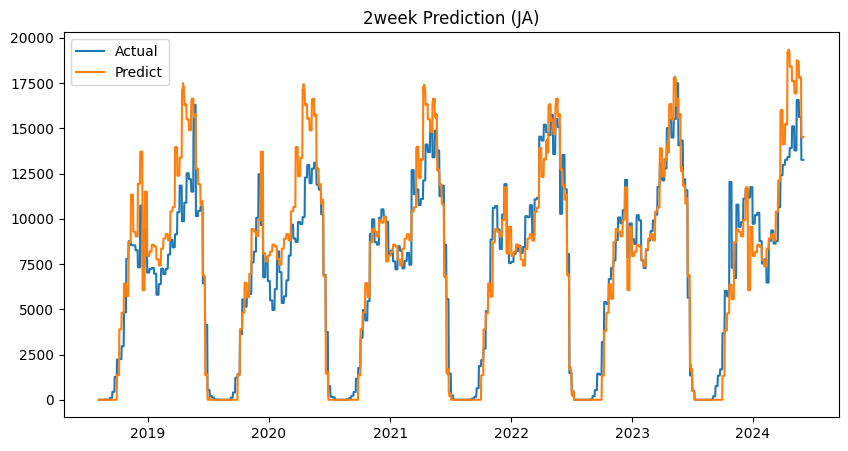

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('2week Prediction (JA)')
plt.plot(df_val1.index, df_val3['Ans'], label='Actual')
plt.plot(df_val1.index, df_val3['Pred'], label='Predict')
plt.legend()
plt.show()
plt.close()

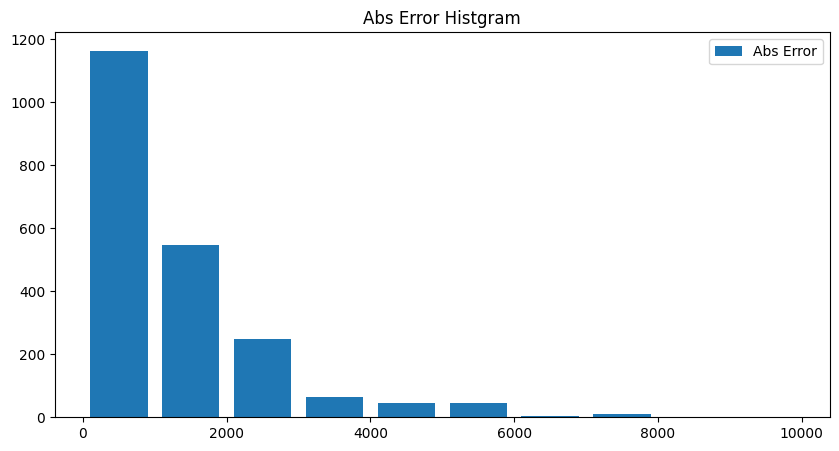

0~1000 :	 1164
1000~2000 :	 546
2000~3000 :	 250
3000~4000 :	 64
4000~5000 :	 45
5000~6000 :	 44
6000~7000 :	 4
7000~8000 :	 10
8000~9000 :	 0
9000~10000 :	 0


In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Abs Error Histgram')
n, bins, patches = plt.hist(df_val3['Abs Error'], range=(0, 10000), bins=10, label='Abs Error', rwidth=0.8)
plt.legend()
plt.show()
plt.close()
for i in range(len(n)):
    print(str(int(bins[i]))+'~'+str(int(bins[i+1])), ':\t', int(n[i]))

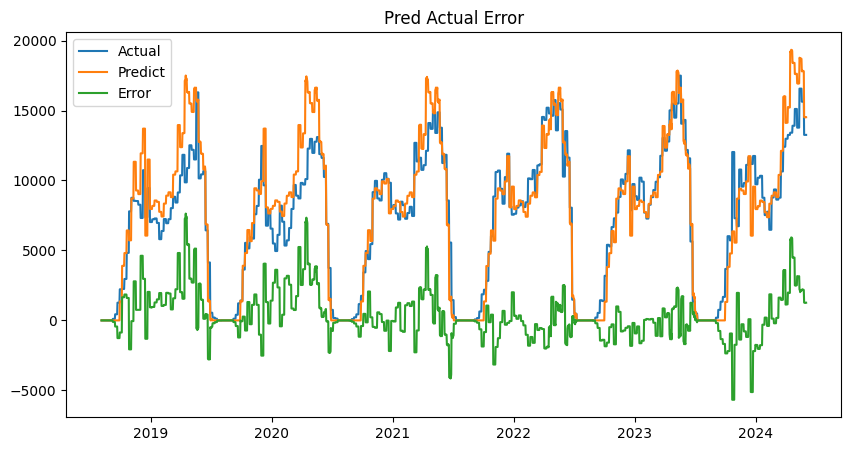

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Pred Actual Error')
plt.plot(df_val3.index, df_val3['Ans'], label='Actual')
plt.plot(df_val3.index, df_val3['Pred'], label='Predict')
plt.plot(df_val3.index, df_val3['Error'], label='Error')
plt.legend()
plt.show()
plt.close()

In [ ]:
# 評価指標を計算（Abs Errorが0の行を除いて計算）
val_max_error3 = df_val3[df_val3['Abs Error'] != 0]['Abs Error'].max()
val_max_error3_day = df_val3[df_val3['Abs Error'] != 0]['Abs Error'].idxmax().date().isoformat()
val_max_error_rate3 = df_val3[(df_val3['Abs Error'] != 0) & (df_val3['Abs Error Rate'] < 1)]['Abs Error Rate'].max()
val_max_error_rate3_day = df_val3[(df_val3['Abs Error'] != 0) & (df_val3['Abs Error Rate'] < 1)]['Abs Error Rate'].idxmax().date().isoformat()
val_min_error3 = df_val3[df_val3['Abs Error'] != 0]['Abs Error'].min()
val_mean_abs_error3 = df_val3[df_val3['Abs Error'] != 0]['Abs Error'].mean() 
val_mean_abs_error_rate3 = df_val3[df_val3['Abs Error'] != 0]['Abs Error Rate'].mean()
val_under_error1000_num3 = str(len(df_val3[df_val3['Abs Error'] < 1000]['Abs Error'])) + '/' + str(len(df_val3))
val_up_date3 = len(df_val3[df_val3['Error'] > 0])
val_down_date3 = len(df_val3[df_val3['Error'] < 0])

print('平均誤差率:', val_mean_abs_error_rate3)
print('平均誤差:', val_mean_abs_error3)  
print('最大誤差率:', val_max_error_rate3)
print('最大誤差:', val_max_error3)
print('最小誤差:', val_min_error3)
print('最大誤差率日:', val_max_error_rate3_day)
print('最大誤差日:', val_max_error3_day)
print('1000以下の日数:', val_under_error1000_num3)
print(f'誤差が上振れた日数:{val_up_date3}/{len(df_val3)}')
print(f'誤差が下振れた日数:{val_down_date3}/{len(df_val3)}')

平均誤差率: 0.29708483659180823
平均誤差: 1323.1457273822143
最大誤差率: 0.9886960461519456
最大誤差: 7633.509195073941
最小誤差: 1.6666666668169419
最大誤差率日: 2019-07-03
最大誤差日: 2019-04-17
1000以下の日数: 1164/2127
誤差が上振れた日数:915/2127
誤差が下振れた日数:989/2127


#### 出力をTarget2へ変換する際に、不適切なスケーリングをしてしまった場合

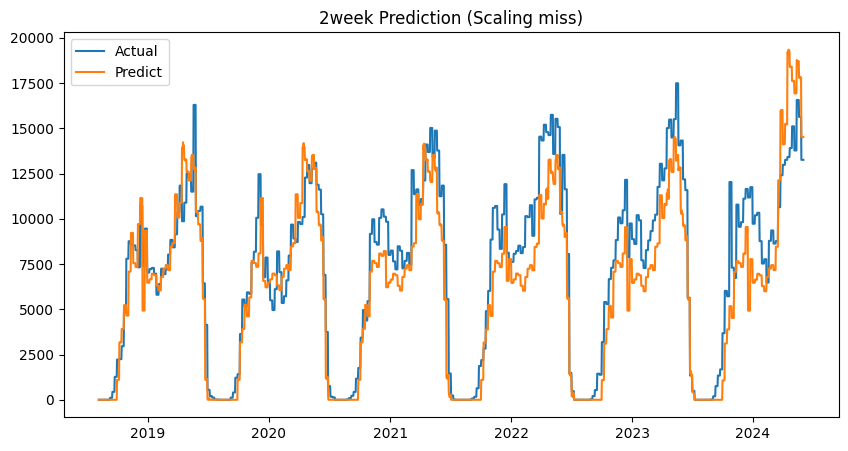

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('2week Prediction (Scaling miss)')
plt.plot(df_val1.index, df_val1['Ans'], label='Actual')
plt.plot(df_val1.index, df_val1['Pred'], label='Predict')
plt.legend()
plt.show()
plt.close()

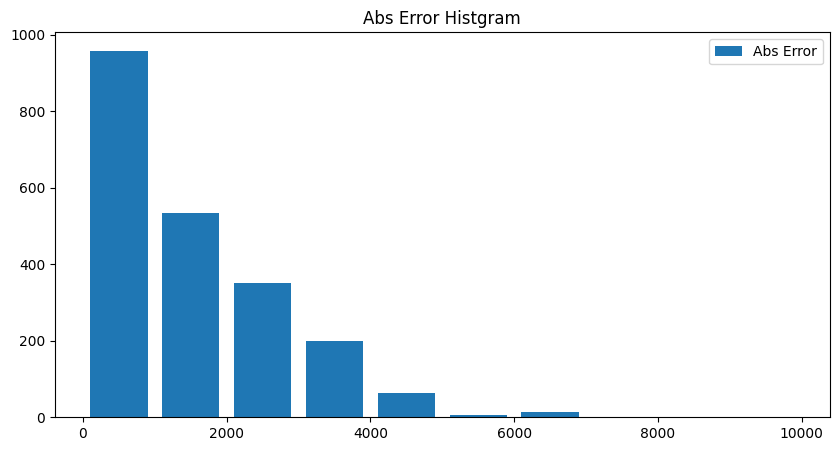

0~1000 :	 958
1000~2000 :	 535
2000~3000 :	 351
3000~4000 :	 198
4000~5000 :	 64
5000~6000 :	 7
6000~7000 :	 14
7000~8000 :	 0
8000~9000 :	 0
9000~10000 :	 0


In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Abs Error Histgram')
n, bins, patches = plt.hist(df_val1['Abs Error'], range=(0, 10000), bins=10, label='Abs Error', rwidth=0.8)
plt.legend()
plt.show()
plt.close()
for i in range(len(n)):
    print(str(int(bins[i]))+'~'+str(int(bins[i+1])), ':\t', int(n[i]))

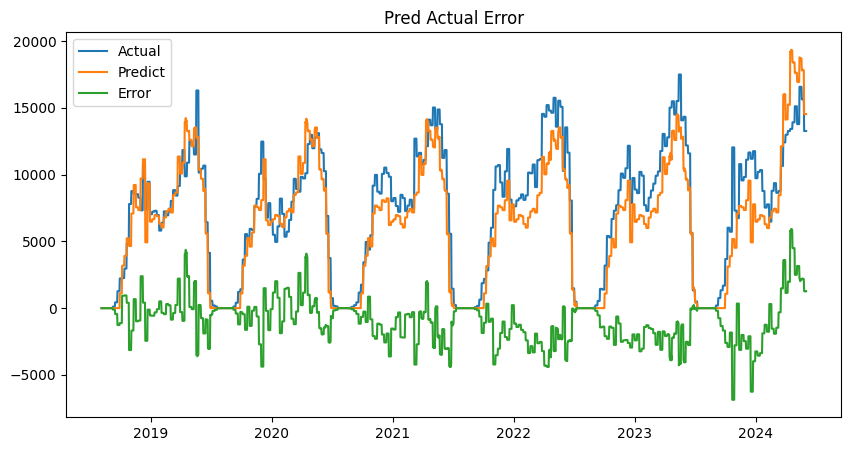

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Pred Actual Error')
plt.plot(df_val1.index, df_val1['Ans'], label='Actual')
plt.plot(df_val1.index, df_val1['Pred'], label='Predict')
plt.plot(df_val1.index, df_val1['Error'], label='Error')
plt.legend()
plt.show()
plt.close()

In [ ]:
# 評価指標を計算（Abs Errorが0の行を除いて計算）
val_max_error1 = df_val1[df_val1['Abs Error'] != 0]['Abs Error'].max()
val_max_error1_day = df_val1[df_val1['Abs Error'] != 0]['Abs Error'].idxmax().date().isoformat()
val_max_error_rate1 = df_val1[(df_val1['Abs Error'] != 0) & (df_val1['Abs Error Rate'] < 1)]['Abs Error Rate'].max()
val_max_error_rate1_day = df_val1[(df_val1['Abs Error'] != 0) & (df_val1['Abs Error Rate'] < 1)]['Abs Error Rate'].idxmax().date().isoformat()
val_min_error1 = df_val1[df_val1['Abs Error'] != 0]['Abs Error'].min()
val_mean_abs_error1 = df_val1[df_val1['Abs Error'] != 0]['Abs Error'].mean() 
val_mean_abs_error_rate1 = df_val1[df_val1['Abs Error'] != 0]['Abs Error Rate'].mean()
val_under_error1000_num1 = str(len(df_val1[df_val1['Abs Error'] < 1000]['Abs Error'])) + '/' + str(len(df_val1))
val_up_date1 = len(df_val1[df_val1['Error'] > 0])
val_down_date1 = len(df_val1[df_val1['Error'] < 0])

print('平均誤差率:', val_mean_abs_error_rate1)
print('平均誤差:', val_mean_abs_error1)  
print('最大誤差率:', val_max_error_rate1)
print('最大誤差:', val_max_error1)
print('最小誤差:', val_min_error1)
print('最大誤差率日:', val_max_error_rate1_day)
print('最大誤差日:', val_max_error1_day)
print('1000以下の日数:', val_under_error1000_num1)
print(f'誤差が上振れた日数:{val_up_date1}/{len(df_val1)}')
print(f'誤差が下振れた日数:{val_down_date1}/{len(df_val1)}')

平均誤差率: 0.31619700710319665
平均誤差: 1581.961511141251
最大誤差率: 0.9908080300307518
最大誤差: 6860.722860785509
最小誤差: 1.6666666668169419
最大誤差率日: 2019-07-03
最大誤差日: 2023-10-27
1000以下の日数: 958/2127
誤差が上振れた日数:360/2127
誤差が下振れた日数:1544/2127


#### 出力を適切に変換した場合

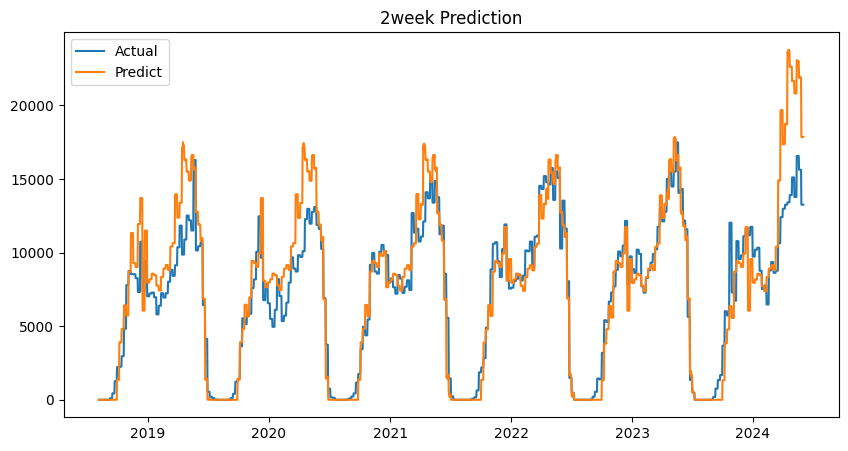

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('2week Prediction')
plt.plot(df_val2.index, df_val2['Ans'], label='Actual')
plt.plot(df_val2.index, df_val2['Pred'], label='Predict')
plt.legend()
plt.show()
plt.close()

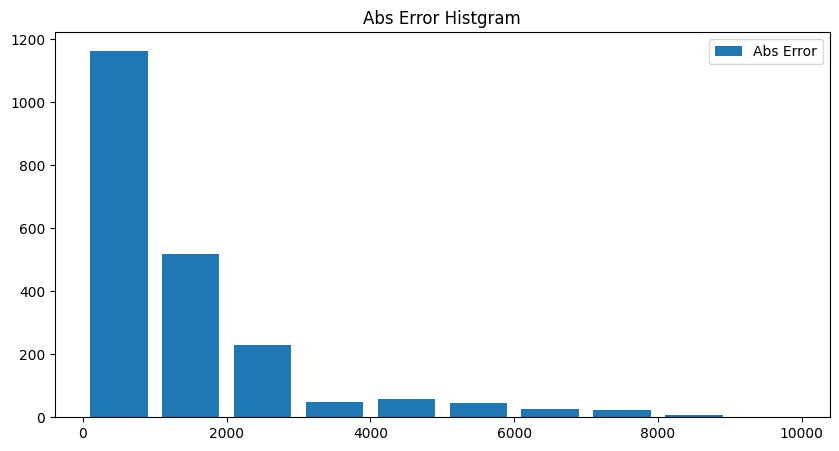

0~1000 :	 1164
1000~2000 :	 518
2000~3000 :	 229
3000~4000 :	 50
4000~5000 :	 59
5000~6000 :	 44
6000~7000 :	 25
7000~8000 :	 24
8000~9000 :	 7
9000~10000 :	 0


In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Abs Error Histgram')
n, bins, patches = plt.hist(df_val2['Abs Error'], range=(0, 10000), bins=10, label='Abs Error', rwidth=0.8)
plt.legend()
plt.show()
plt.close()
for i in range(len(n)):
    print(str(int(bins[i]))+'~'+str(int(bins[i+1])), ':\t', int(n[i]))

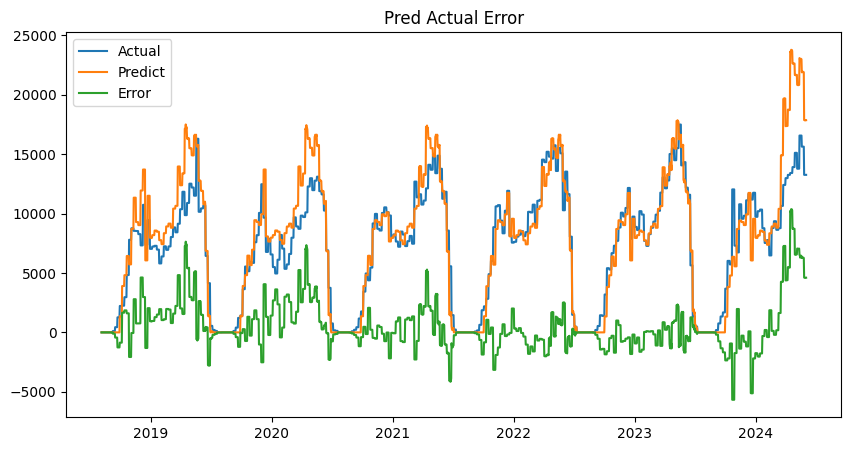

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Pred Actual Error')
plt.plot(df_val2.index, df_val2['Ans'], label='Actual')
plt.plot(df_val2.index, df_val2['Pred'], label='Predict')
plt.plot(df_val2.index, df_val2['Error'], label='Error')
plt.legend()
plt.show()
plt.close()

In [ ]:
val_max_error2 = df_val2[df_val2['Abs Error'] != 0]['Abs Error'].max()
val_max_error2_day = df_val2[df_val2['Abs Error'] != 0]['Abs Error'].idxmax().date().isoformat()
val_max_error_rate2 = df_val2[(df_val2['Abs Error'] != 0) & (df_val2['Abs Error Rate'] < 1)]['Abs Error Rate'].max()
val_max_error_rate2_day = df_val2[(df_val2['Abs Error'] != 0) & (df_val2['Abs Error Rate'] < 1)]['Abs Error Rate'].idxmax().date().isoformat()
val_min_error2 = df_val2[df_val2['Abs Error'] != 0]['Abs Error'].min()
val_mean_abs_error2 = df_val2[df_val2['Abs Error'] != 0]['Abs Error'].mean()
val_mean_abs_error_rate2 = df_val2[df_val2['Abs Error'] != 0]['Abs Error Rate'].mean()
val_under_error1000_num2 = str(len(df_val2[df_val2['Abs Error'] < 1000]['Abs Error'])) + '/' + str(len(df_val2))
val_up_date2 = len(df_val2[df_val2['Error'] > 0])
val_down_date2 = len(df_val2[df_val2['Error'] < 0])

print('平均誤差率:', val_mean_abs_error_rate2)
print('平均誤差:', val_mean_abs_error2)
print('最大誤差率:', val_max_error_rate2)
print('最大誤差:', val_max_error2)
print('最小誤差:', val_min_error2)
print('最大誤差率日:', val_max_error_rate2_day)
print('最大誤差日:', val_max_error2_day)
print('1000以下の日数:', val_under_error1000_num2)
print(f'誤差が上振れた日数:{val_up_date2}/{len(df_val2)}')
print(f'誤差が下振れた日数:{val_down_date2}/{len(df_val2)}')

平均誤差率: 0.3082189147015251
平均誤差: 1475.7849032460413
最大誤差率: 0.9886960461519456
最大誤差: 10369.90486532701
最小誤差: 1.6666666668169419
最大誤差率日: 2019-07-03
最大誤差日: 2024-04-17
1000以下の日数: 1164/2127
誤差が上振れた日数:915/2127
誤差が下振れた日数:989/2127


### 2023年度の予測結果


### JAへ返信した予測結果の再現

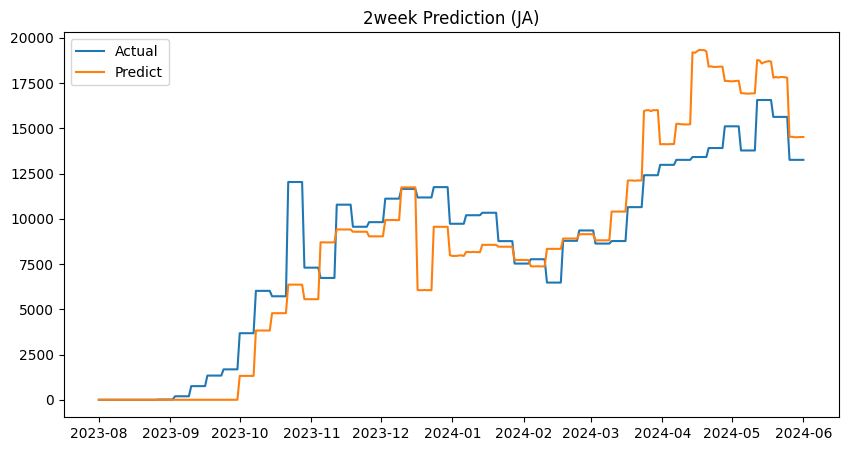

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('2week Prediction (JA)')
plt.plot(df_val3['Ans']['2023/08/01':], label='Actual')
plt.plot(df_val3['Pred']['2023/08/01':], label='Predict')
plt.legend()
plt.show()
plt.close()

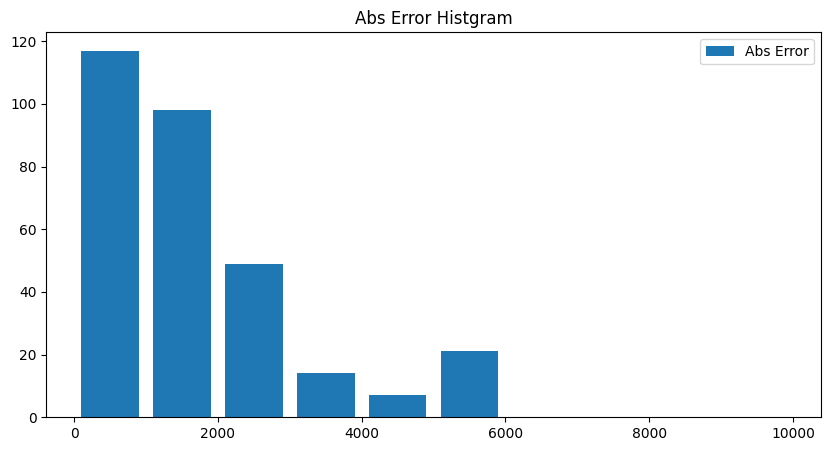

0~1000 :	 117
1000~2000 :	 98
2000~3000 :	 49
3000~4000 :	 14
4000~5000 :	 7
5000~6000 :	 21
6000~7000 :	 0
7000~8000 :	 0
8000~9000 :	 0
9000~10000 :	 0


In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Abs Error Histgram')
n, bins, patches = plt.hist(df_val3['Abs Error']['2023/08/01':], range=(0, 10000), bins=10, label='Abs Error', rwidth=0.8)
plt.legend()
plt.show()
plt.close()
for i in range(len(n)):
    print(str(int(bins[i]))+'~'+str(int(bins[i+1])), ':\t', int(n[i]))

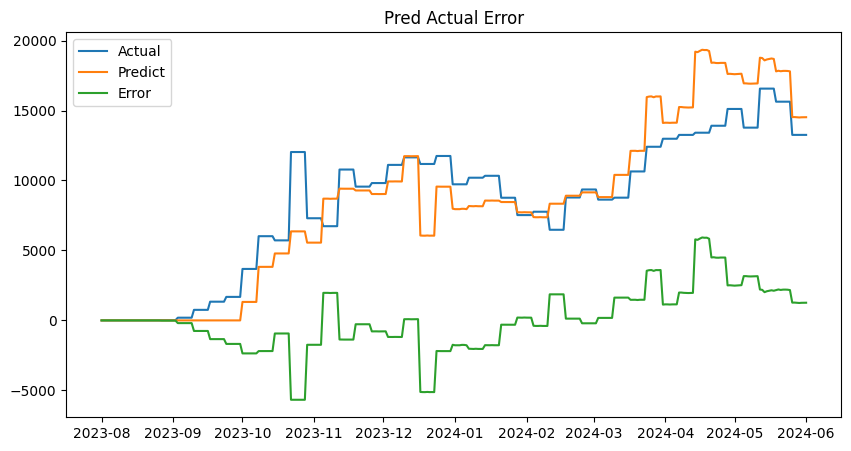

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Pred Actual Error')
plt.plot(df_val3['Ans']['2023/08/01':], label='Actual')
plt.plot(df_val3['Pred']['2023/08/01':], label='Predict')
plt.plot(df_val3['Error']['2023/08/01':], label='Error')
plt.legend()
plt.show()
plt.close()

In [ ]:
# 評価指標を計算（Abs Errorが0の行を除いて計算）
val_max_error3 = df_val3[df_val3['Abs Error'] != 0]['Abs Error']['2023/08/01':].max()
val_max_error3_day = df_val3[df_val3['Abs Error'] != 0]['Abs Error']['2023/08/01':].idxmax().date().isoformat()
val_max_error_rate3 = df_val3[(df_val3['Abs Error'] != 0) & (df_val3['Abs Error Rate'] < 1)]['Abs Error Rate']['2023/08/01':].max()
val_max_error_rate3_day = df_val3[(df_val3['Abs Error'] != 0) & (df_val3['Abs Error Rate'] < 1)]['Abs Error Rate']['2023/08/01':].idxmax().date().isoformat()
val_min_error3 = df_val3[df_val3['Abs Error'] != 0]['Abs Error']['2023/08/01':].min()
val_mean_abs_error3 = df_val3[df_val3['Abs Error'] != 0]['Abs Error']['2023/08/01':].mean() 
val_mean_abs_error_rate3 = df_val3[df_val3['Abs Error'] != 0]['Abs Error Rate']['2023/08/01':].mean()
val_under_error1000_num3 = str(len(df_val3[df_val3['Abs Error'] < 1000]['Abs Error']['2023/08/01':])) + '/' + str(len(df_val3['2023/08/01':]))
val_up_date3 = len(df_val3[df_val3['Error'] > 0]['2023/08/01':])
val_down_date3 = len(df_val3[df_val3['Error'] < 0]['2023/08/01':])

print('平均誤差率:', val_mean_abs_error_rate3)
print('平均誤差:', val_mean_abs_error3)  
print('最大誤差率:', val_max_error_rate3)
print('最大誤差:', val_max_error3)
print('最小誤差:', val_min_error3)
print('最大誤差率日:', val_max_error_rate3_day)
print('最大誤差日:', val_max_error3_day)
print('1000以下の日数:', val_under_error1000_num3)
print(f'誤差が上振れた日数:{val_up_date3}/{len(df_val3["2023/08/01":])}')
print(f'誤差が下振れた日数:{val_down_date3}/{len(df_val3["2023/08/01":])}')

平均誤差率: 0.2885058776653484
平均誤差: 1751.7386539956888
最大誤差率: 0.641084492157914
最大誤差: 5926.278888764509
最小誤差: 15.333333334715867
最大誤差率日: 2023-10-01
最大誤差日: 2024-04-17
1000以下の日数: 117/306
誤差が上振れた日数:126/306
誤差が下振れた日数:154/306


#### 出力をTarget2へ変換する際に、不適切なスケーリングをしてしまった場合

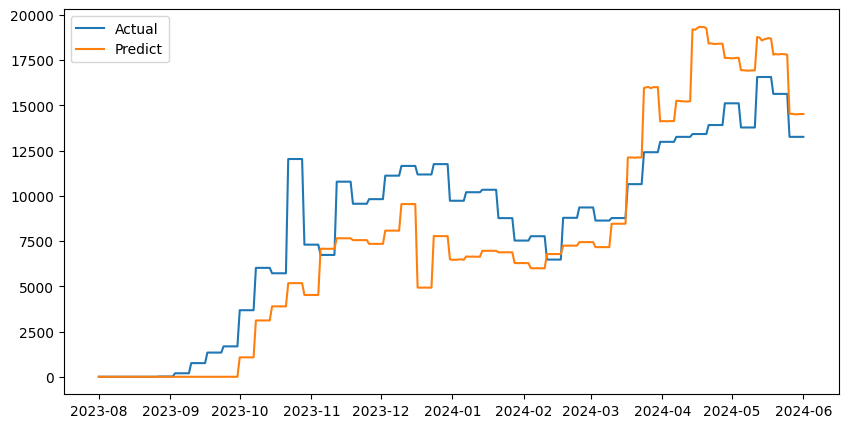

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df_val1['Ans']['2023/08/01':], label='Actual')
plt.plot(df_val1['Pred']['2023/08/01':], label='Predict')
plt.legend()
plt.show()
plt.close()

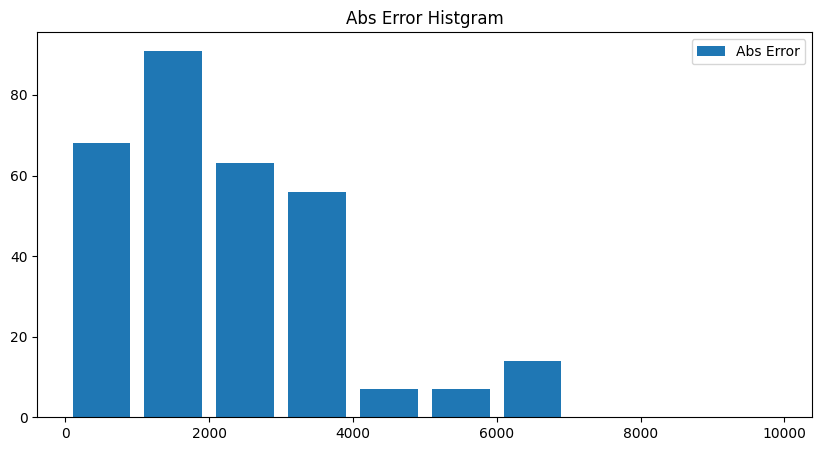

0~1000 :	 68
1000~2000 :	 91
2000~3000 :	 63
3000~4000 :	 56
4000~5000 :	 7
5000~6000 :	 7
6000~7000 :	 14
7000~8000 :	 0
8000~9000 :	 0
9000~10000 :	 0


In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Abs Error Histgram')
n, bins, patches = plt.hist(df_val1['Abs Error']['2023/08/01':], range=(0, 10000), bins=10, label='Abs Error', rwidth=0.8)
plt.legend()
plt.show()
plt.close()
for i in range(len(n)):
    print(str(int(bins[i]))+'~'+str(int(bins[i+1])), ':\t', int(n[i]))

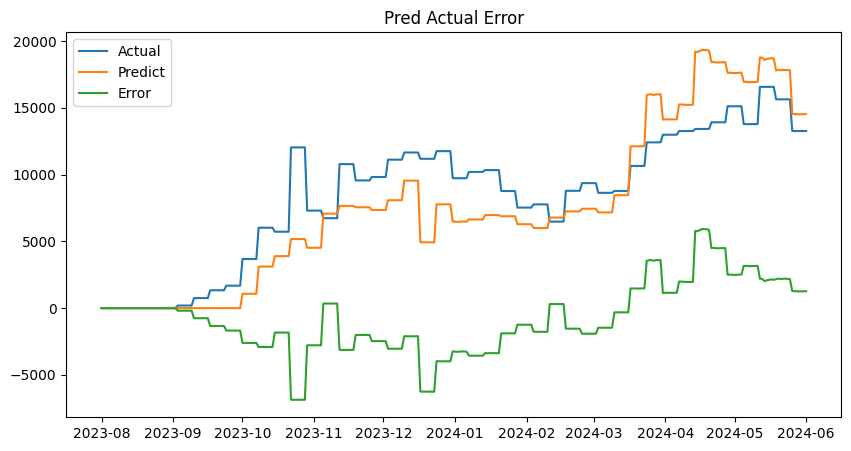

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Pred Actual Error')
plt.plot(df_val1['Ans']['2023/08/01':], label='Actual')
plt.plot(df_val1['Pred']['2023/08/01':], label='Predict')
plt.plot(df_val1['Error']['2023/08/01':], label='Error')
plt.legend()
plt.show()
plt.close()

In [ ]:
# 評価指標を計算（Abs Errorが0の行を除いて計算）
val_max_error1 = df_val1[df_val1['Abs Error'] != 0]['Abs Error']['2023/08/01':].max()
val_max_error1_day = df_val1[df_val1['Abs Error'] != 0]['Abs Error']['2023/08/01':].idxmax().date().isoformat()
val_max_error_rate1 = df_val1[(df_val1['Abs Error'] != 0) & (df_val1['Abs Error Rate'] < 1)]['Abs Error Rate']['2023/08/01':].max()
val_max_error_rate1_day = df_val1[(df_val1['Abs Error'] != 0) & (df_val1['Abs Error Rate'] < 1)]['Abs Error Rate']['2023/08/01':].idxmax().date().isoformat()
val_min_error1 = df_val1[df_val1['Abs Error'] != 0]['Abs Error']['2023/08/01':].min()
val_mean_abs_error1 = df_val1[df_val1['Abs Error'] != 0]['Abs Error']['2023/08/01':].mean() 
val_mean_abs_error_rate1 = df_val1[df_val1['Abs Error'] != 0]['Abs Error Rate']['2023/08/01':].mean()
val_under_error1000_num1 = str(len(df_val1[df_val1['Abs Error'] < 1000]['Abs Error']['2023/08/01':])) + '/' + str(len(df_val1['2023/08/01':]))
val_up_date1 = len(df_val1[df_val1['Error'] > 0]["2023/08/01":])
val_down_date1 = len(df_val1[df_val1['Error'] < 0]["2023/08/01":])

print('平均誤差率:', val_mean_abs_error_rate1)
print('平均誤差:', val_mean_abs_error1)  
print('最大誤差率:', val_max_error_rate1)
print('最大誤差:', val_max_error1)
print('最小誤差:', val_min_error1)
print('最大誤差率日:', val_max_error_rate1_day)
print('最大誤差日:', val_max_error1_day)
print('1000以下の日数:', val_under_error1000_num1)
print(f'誤差が上振れた日数:{val_up_date1}/{len(df_val1["2023/08/01":])}')
print(f'誤差が下振れた日数:{val_down_date1}/{len(df_val1["2023/08/01":])}')

平均誤差率: 0.3512132669015612
平均誤差: 2366.426719356681
最大誤差率: 0.7081428047585063
最大誤差: 6860.722860785509
最小誤差: 15.333333334715867
最大誤差率日: 2023-10-01
最大誤差日: 2023-10-27
1000以下の日数: 68/306
誤差が上振れた日数:91/306
誤差が下振れた日数:189/306


#### 出力を適切に変換した場合

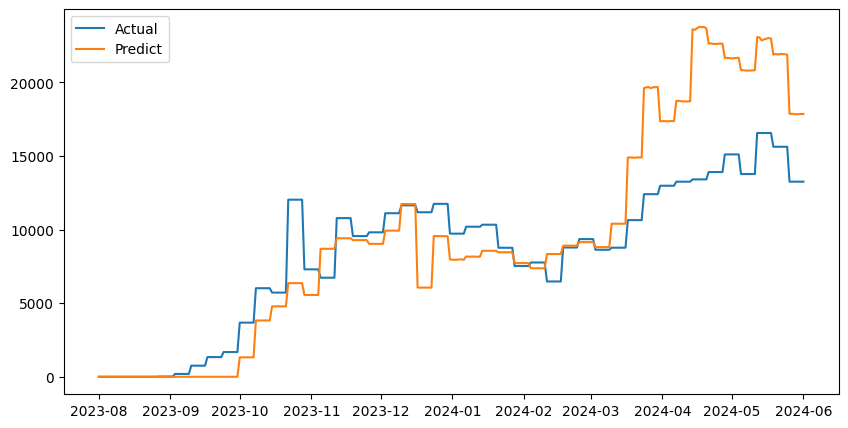

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df_val2['Ans']['2023/08/01':], label='Actual')
plt.plot(df_val2['Pred']['2023/08/01':], label='Predict')
plt.legend()
plt.show()
plt.close()

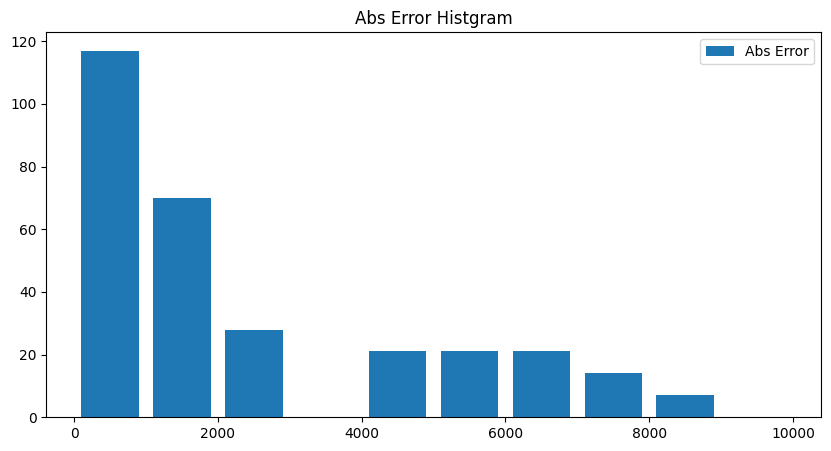

0~1000 :	 117
1000~2000 :	 70
2000~3000 :	 28
3000~4000 :	 0
4000~5000 :	 21
5000~6000 :	 21
6000~7000 :	 21
7000~8000 :	 14
8000~9000 :	 7
9000~10000 :	 0


In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Abs Error Histgram')
n, bins, patches = plt.hist(df_val2['Abs Error']['2023/08/01':], range=(0, 10000), bins=10, label='Abs Error', rwidth=0.8)
plt.legend()
plt.show()
plt.close()
for i in range(len(n)):
    print(str(int(bins[i]))+'~'+str(int(bins[i+1])), ':\t', int(n[i]))

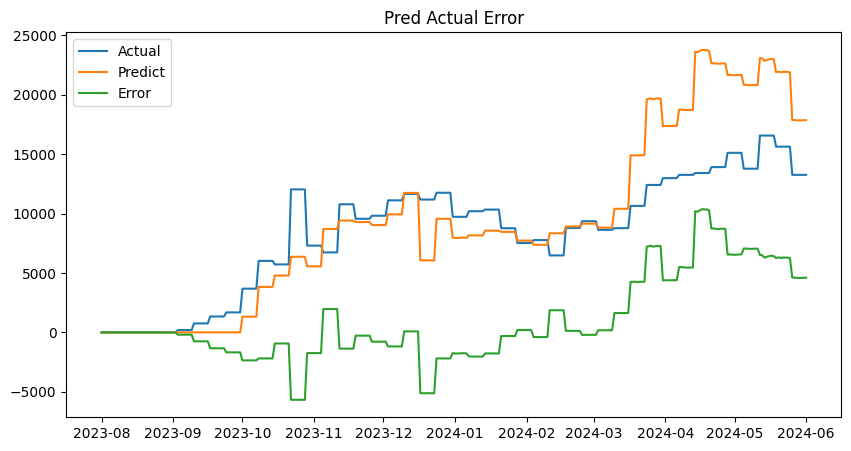

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Pred Actual Error')
plt.plot(df_val2['Ans']['2023/08/01':], label='Actual')
plt.plot(df_val2['Pred']['2023/08/01':], label='Predict')
plt.plot(df_val2['Error']['2023/08/01':], label='Error')
plt.legend()
plt.show()
plt.close()

In [ ]:
val_max_error2 = df_val2[df_val2['Abs Error'] != 0]['Abs Error']['2023/08/01':].max()
val_max_error2_day = df_val2[df_val2['Abs Error'] != 0]['Abs Error']['2023/08/01':].idxmax().date().isoformat()
val_max_error_rate2 = df_val2[(df_val2['Abs Error'] != 0) & (df_val2['Abs Error Rate'] < 1)]['Abs Error Rate']['2023/08/01':].max()
val_max_error_rate2_day = df_val2[(df_val2['Abs Error'] != 0) & (df_val2['Abs Error Rate'] < 1)]['Abs Error Rate']['2023/08/01':].idxmax().date().isoformat()
val_min_error2 = df_val2[df_val2['Abs Error'] != 0]['Abs Error']['2023/08/01':].min()
val_mean_abs_error2 = df_val2[df_val2['Abs Error'] != 0]['Abs Error']['2023/08/01':].mean()
val_mean_abs_error_rate2 = df_val2[df_val2['Abs Error'] != 0]['Abs Error Rate']['2023/08/01':].mean()
val_under_error1000_num2 = str(len(df_val2[df_val2['Abs Error'] < 1000]['Abs Error']['2023/08/01':])) + '/' + str(len(df_val2['2023/08/01':]))
val_up_date2 = len(df_val2[df_val2['Error'] > 0]["2023/08/01":])
val_down_date2 = len(df_val2[df_val2['Error'] < 0]["2023/08/01":])

print('平均誤差率:', val_mean_abs_error_rate2)
print('平均誤差:', val_mean_abs_error2)
print('最大誤差率:', val_max_error_rate2)
print('最大誤差:', val_max_error2)
print('最小誤差:', val_min_error2)
print('最大誤差率日:', val_max_error_rate2_day)
print('最大誤差日:', val_max_error2_day)
print('1000以下の日数:', val_under_error1000_num2)
print(f'誤差が上振れた日数:{val_up_date2}/{len(df_val2["2023/08/01":])}')
print(f'誤差が下振れた日数:{val_down_date2}/{len(df_val2["2023/08/01":])}')

平均誤差率: 0.36421760881142295
平均誤差: 2789.685049869712
最大誤差率: 0.7730850275384809
最大誤差: 10369.90486532701
最小誤差: 15.333333334715867
最大誤差率日: 2024-04-17
最大誤差日: 2024-04-17
1000以下の日数: 117/306
誤差が上振れた日数:126/306
誤差が下振れた日数:154/306


### 学習期間を含む全期間での予測結果(1週間後予測)

#### JAへ返信した予測結果の再現

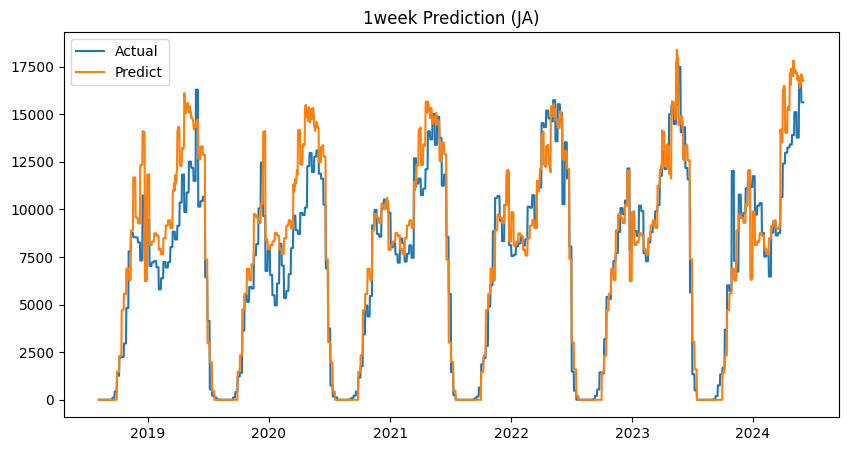

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('1week Prediction (JA)')
plt.plot(df_week1_val1.index, df_week1_val3['Ans'], label='Actual')
plt.plot(df_week1_val1.index, df_week1_val3['Pred'], label='Predict')
plt.legend()
plt.show()
plt.close()

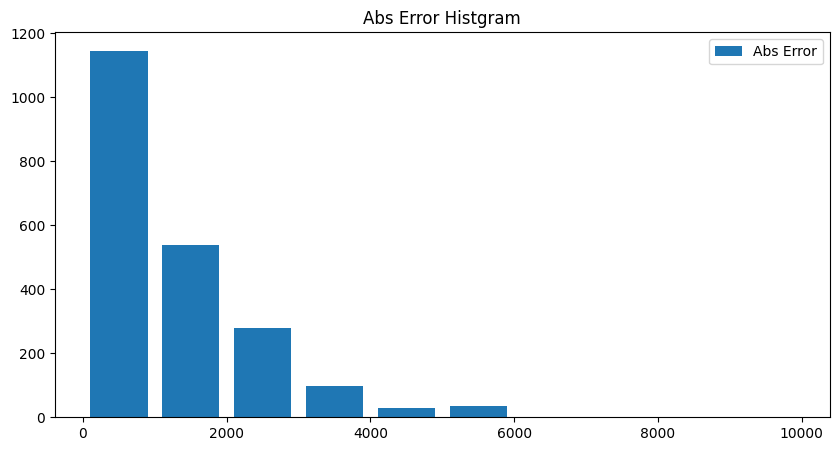

0~1000 :	 1146
1000~2000 :	 539
2000~3000 :	 278
3000~4000 :	 98
4000~5000 :	 28
5000~6000 :	 36
6000~7000 :	 2
7000~8000 :	 0
8000~9000 :	 0
9000~10000 :	 0


In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Abs Error Histgram')
n, bins, patches = plt.hist(df_week1_val3['Abs Error'], range=(0, 10000), bins=10, label='Abs Error', rwidth=0.8)
plt.legend()
plt.show()
plt.close()
for i in range(len(n)):
    print(str(int(bins[i]))+'~'+str(int(bins[i+1])), ':\t', int(n[i]))

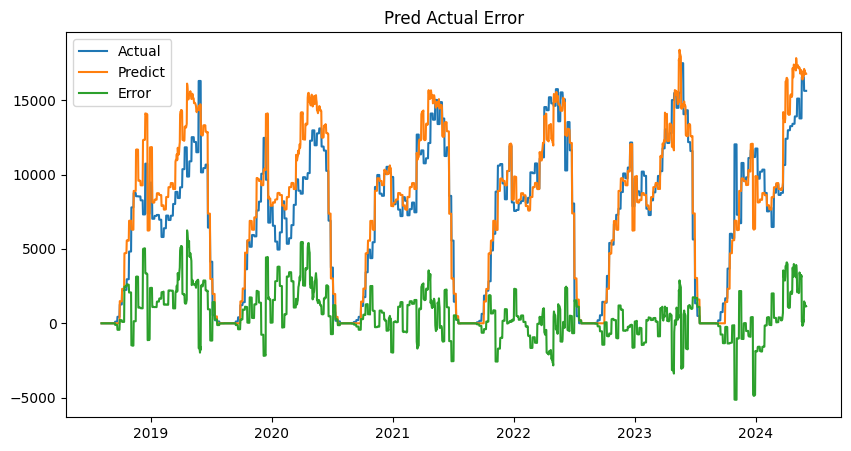

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Pred Actual Error')
plt.plot(df_week1_val3.index, df_week1_val3['Ans'], label='Actual')
plt.plot(df_week1_val3.index, df_week1_val3['Pred'], label='Predict')
plt.plot(df_week1_val3.index, df_week1_val3['Error'], label='Error')
plt.legend()
plt.show()
plt.close()

In [ ]:
# 評価指標を計算（Abs Errorが0の行を除いて計算）
val_max_error3 = df_week1_val3[df_week1_val3['Abs Error'] != 0]['Abs Error'].max()
val_max_error3_day = df_week1_val3[df_week1_val3['Abs Error'] != 0]['Abs Error'].idxmax().date().isoformat()
val_max_error_rate3 = df_week1_val3[(df_week1_val3['Abs Error'] != 0) & (df_week1_val3['Abs Error Rate'] < 1)]['Abs Error Rate'].max()
val_max_error_rate3_day = df_week1_val3[(df_week1_val3['Abs Error'] != 0) & (df_week1_val3['Abs Error Rate'] < 1)]['Abs Error Rate'].idxmax().date().isoformat()
val_min_error3 = df_week1_val3[df_week1_val3['Abs Error'] != 0]['Abs Error'].min()
val_mean_abs_error3 = df_week1_val3[df_week1_val3['Abs Error'] != 0]['Abs Error'].mean() 
val_mean_abs_error_rate3 = df_week1_val3[df_week1_val3['Abs Error'] != 0]['Abs Error Rate'].mean()
val_under_error1000_num3 = str(len(df_week1_val3[df_week1_val3['Abs Error'] < 1000]['Abs Error'])) + '/' + str(len(df_week1_val3))
val_up_date3 = len(df_week1_val3[df_week1_val3['Error'] > 0])
val_down_date3 = len(df_week1_val3[df_week1_val3['Error'] < 0])

print('平均誤差率:', val_mean_abs_error_rate3)
print('平均誤差:', val_mean_abs_error3)  
print('最大誤差率:', val_max_error_rate3)
print('最大誤差:', val_max_error3)
print('最小誤差:', val_min_error3)
print('最大誤差率日:', val_max_error_rate3_day)
print('最大誤差日:', val_max_error3_day)
print('1000以下の日数:', val_under_error1000_num3)
print(f'誤差が上振れた日数:{val_up_date3}/{len(df_week1_val3)}')
print(f'誤差が下振れた日数:{val_down_date3}/{len(df_week1_val3)}')

平均誤差率: 0.47439374011992363
平均誤差: 1282.002429752698
最大誤差率: 0.8870123286566104
最大誤差: 6249.668863042691
最小誤差: 1.6666666668169419
最大誤差率日: 2018-10-23
最大誤差日: 2019-04-21
1000以下の日数: 1146/2127
誤差が上振れた日数:1203/2127
誤差が下振れた日数:694/2127


### 2023年度の予測結果

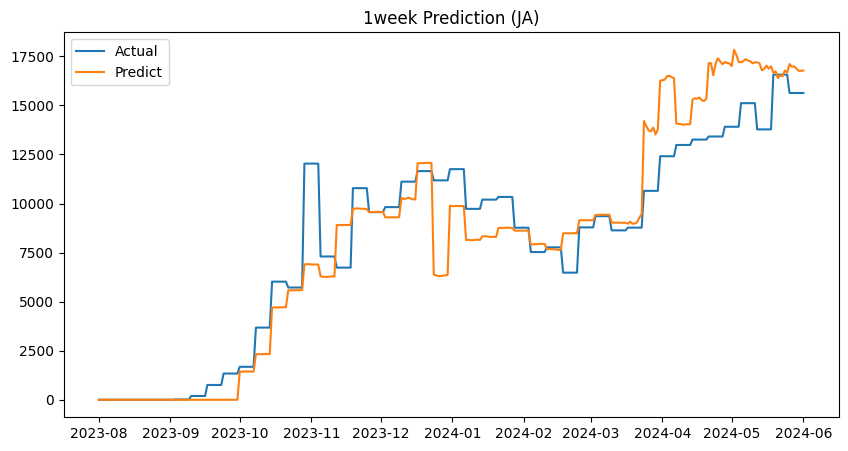

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('1week Prediction (JA)')
plt.plot(df_week1_val3['Ans']['2023/08/01':], label='Actual')
plt.plot(df_week1_val3['Pred']['2023/08/01':], label='Predict')
plt.legend()
plt.show()
plt.close()

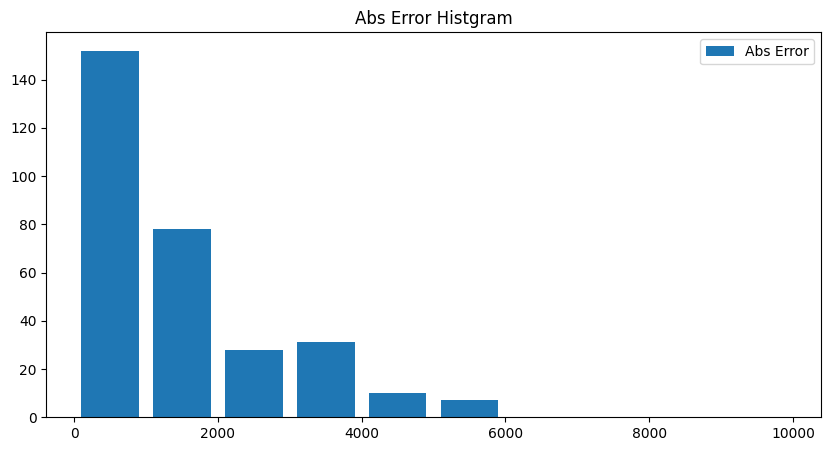

0~1000 :	 152
1000~2000 :	 78
2000~3000 :	 28
3000~4000 :	 31
4000~5000 :	 10
5000~6000 :	 7
6000~7000 :	 0
7000~8000 :	 0
8000~9000 :	 0
9000~10000 :	 0


In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Abs Error Histgram')
n, bins, patches = plt.hist(df_week1_val3['Abs Error']['2023/08/01':], range=(0, 10000), bins=10, label='Abs Error', rwidth=0.8)
plt.legend()
plt.show()
plt.close()
for i in range(len(n)):
    print(str(int(bins[i]))+'~'+str(int(bins[i+1])), ':\t', int(n[i]))

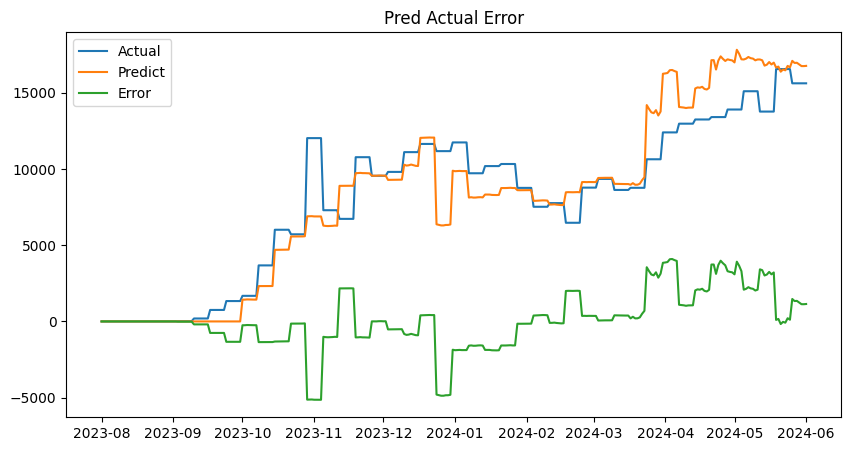

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Pred Actual Error')
plt.plot(df_week1_val3['Ans']['2023/08/01':], label='Actual')
plt.plot(df_week1_val3['Pred']['2023/08/01':], label='Predict')
plt.plot(df_week1_val3['Error']['2023/08/01':], label='Error')
plt.legend()
plt.show()
plt.close()

In [ ]:
# 評価指標を計算（Abs Errorが0の行を除いて計算）
val_max_error3 = df_week1_val3[df_week1_val3['Abs Error'] != 0]['Abs Error']['2023/08/01':].max()
val_max_error3_day = df_week1_val3[df_week1_val3['Abs Error'] != 0]['Abs Error']['2023/08/01':].idxmax().date().isoformat()
val_max_error_rate3 = df_week1_val3[(df_week1_val3['Abs Error'] != 0) & (df_week1_val3['Abs Error Rate'] < 1)]['Abs Error Rate']['2023/08/01':].max()
val_max_error_rate3_day = df_week1_val3[(df_week1_val3['Abs Error'] != 0) & (df_week1_val3['Abs Error Rate'] < 1)]['Abs Error Rate']['2023/08/01':].idxmax().date().isoformat()
val_min_error3 = df_week1_val3[df_week1_val3['Abs Error'] != 0]['Abs Error']['2023/08/01':].min()
val_mean_abs_error3 = df_week1_val3[df_week1_val3['Abs Error'] != 0]['Abs Error']['2023/08/01':].mean() 
val_mean_abs_error_rate3 = df_week1_val3[df_week1_val3['Abs Error'] != 0]['Abs Error Rate']['2023/08/01':].mean()
val_under_error1000_num3 = str(len(df_week1_val3[df_week1_val3['Abs Error'] < 1000]['Abs Error']['2023/08/01':])) + '/' + str(len(df_week1_val3['2023/08/01':]))
val_up_date3 = len(df_week1_val3[df_week1_val3['Error'] > 0]['2023/08/01':])
val_down_date3 = len(df_week1_val3[df_week1_val3['Error'] < 0]['2023/08/01':])

print('平均誤差率:', val_mean_abs_error_rate3)
print('平均誤差:', val_mean_abs_error3)  
print('最大誤差率:', val_max_error_rate3)
print('最大誤差:', val_max_error3)
print('最小誤差:', val_min_error3)
print('最大誤差率日:', val_max_error_rate3_day)
print('最大誤差日:', val_max_error3_day)
print('1000以下の日数:', val_under_error1000_num3)
print(f'誤差が上振れた日数:{val_up_date3}/{len(df_week1_val3["2023/08/01":])}')
print(f'誤差が下振れた日数:{val_down_date3}/{len(df_week1_val3["2023/08/01":])}')

平均誤差率: 0.2401175383366838
平均誤差: 1440.4435547108242
最大誤差率: 0.43621434708964546
最大誤差: 5142.703451605821
最小誤差: 1.680215609341758
最大誤差率日: 2023-12-26
最大誤差日: 2023-11-04
1000以下の日数: 152/306
誤差が上振れた日数:130/306
誤差が下振れた日数:143/306


### 学習期間を含む全期間での予測結果(3週間後予測)

#### JAへ返信した予測結果の再現

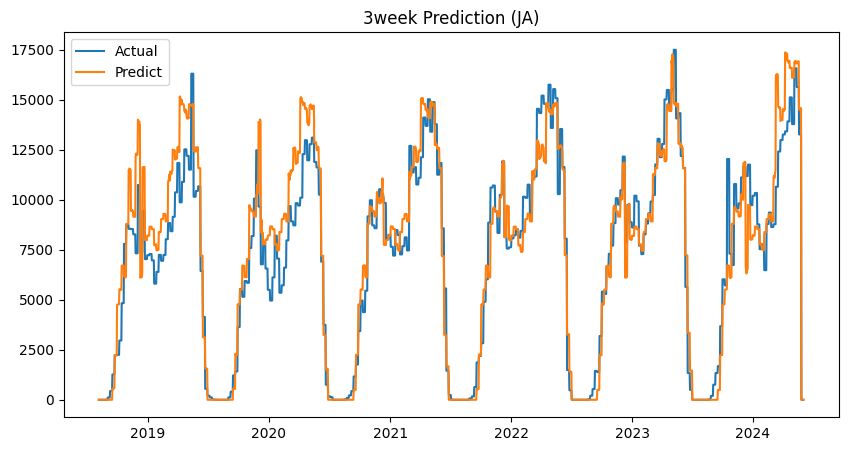

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('3week Prediction (JA)')
plt.plot(df_week3_val1.index, df_week3_val3['Ans'], label='Actual')
plt.plot(df_week3_val1.index, df_week3_val3['Pred'], label='Predict')
plt.legend()
plt.show()
plt.close()

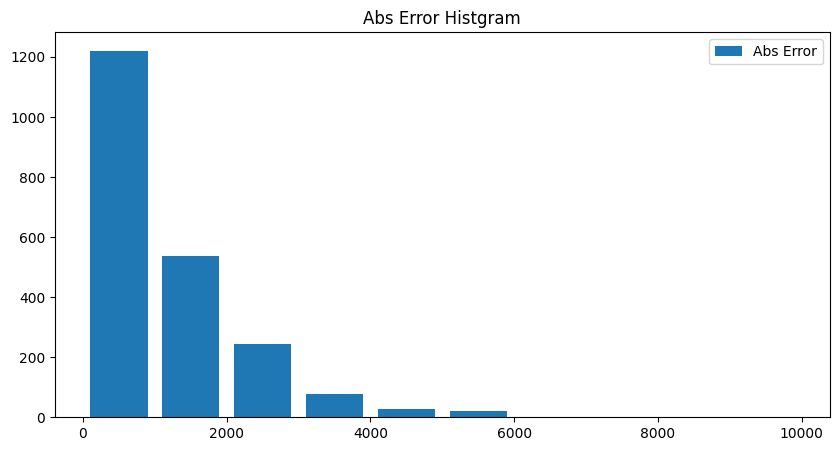

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Abs Error Histgram')
n, bins, patches = plt.hist(df_week3_val3['Abs Error'], range=(0, 10000), bins=10, label='Abs Error', rwidth=0.8)
plt.legend()
plt.show()
plt.close()

0~1000 :	 1221
1000~2000 :	 536
2000~3000 :	 243
3000~4000 :	 78
4000~5000 :	 27
5000~6000 :	 22
6000~7000 :	 0
7000~8000 :	 0
8000~9000 :	 0
9000~10000 :	 0


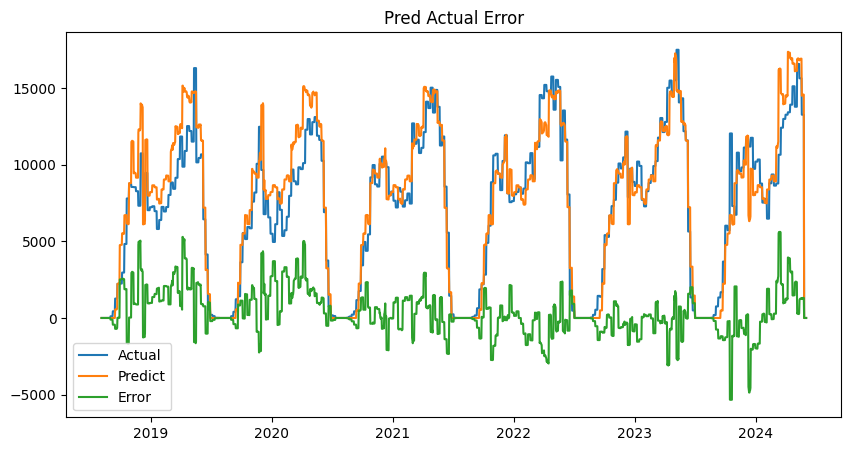

In [ ]:
for i in range(len(n)):
    print(str(int(bins[i]))+'~'+str(int(bins[i+1])), ':\t', int(n[i]))
plt.figure(figsize=(10, 5))
plt.title('Pred Actual Error')
plt.plot(df_week3_val3.index, df_week3_val3['Ans'], label='Actual')
plt.plot(df_week3_val3.index, df_week3_val3['Pred'], label='Predict')
plt.plot(df_week3_val3.index, df_week3_val3['Error'], label='Error')
plt.legend()
plt.show()
plt.close()

In [ ]:
# 評価指標を計算（Abs Errorが0の行を除いて計算）
val_max_error3 = df_week3_val3[df_week3_val3['Abs Error'] != 0]['Abs Error'].max()
val_max_error3_day = df_week3_val3[df_week3_val3['Abs Error'] != 0]['Abs Error'].idxmax().date().isoformat()
val_max_error_rate3 = df_week3_val3[(df_week3_val3['Abs Error'] != 0) & (df_week3_val3['Abs Error Rate'] < 1)]['Abs Error Rate'].max()
val_max_error_rate3_day = df_week3_val3[(df_week3_val3['Abs Error'] != 0) & (df_week3_val3['Abs Error Rate'] < 1)]['Abs Error Rate'].idxmax().date().isoformat()
val_min_error3 = df_week3_val3[df_week3_val3['Abs Error'] != 0]['Abs Error'].min()
val_mean_abs_error3 = df_week3_val3[df_week3_val3['Abs Error'] != 0]['Abs Error'].mean() 
val_mean_abs_error_rate3 = df_week3_val3[df_week3_val3['Abs Error'] != 0]['Abs Error Rate'].mean()
val_under_error1000_num3 = str(len(df_week3_val3[df_week3_val3['Abs Error'] < 1000]['Abs Error'])) + '/' + str(len(df_week3_val3))
val_up_date3 = len(df_week3_val3[df_week3_val3['Error'] > 0])
val_down_date3 = len(df_week3_val3[df_week3_val3['Error'] < 0])

print('平均誤差率:', val_mean_abs_error_rate3)
print('平均誤差:', val_mean_abs_error3)  
print('最大誤差率:', val_max_error_rate3)
print('最大誤差:', val_max_error3)
print('最小誤差:', val_min_error3)
print('最大誤差率日:', val_max_error_rate3_day)
print('最大誤差日:', val_max_error3_day)
print('1000以下の日数:', val_under_error1000_num3)
print(f'誤差が上振れた日数:{val_up_date3}/{len(df_week3_val3)}')
print(f'誤差が下振れた日数:{val_down_date3}/{len(df_week3_val3)}')

平均誤差率: 0.29963477854988696
平均誤差: 1190.5185339341333
最大誤差率: 0.8708335465999097
最大誤差: 5618.327717139178
最小誤差: 0.09110437553135853
最大誤差率日: 2018-10-09
最大誤差日: 2024-03-13
1000以下の日数: 1221/2127
誤差が上振れた日数:1031/2127
誤差が下振れた日数:873/2127


### 2023年度の予測結果

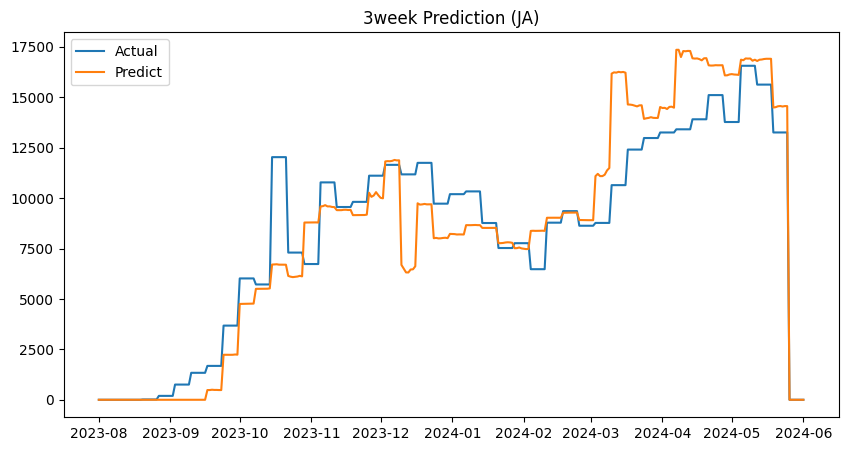

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('3week Prediction (JA)')
plt.plot(df_week3_val3['Ans']['2023/08/01':], label='Actual')
plt.plot(df_week3_val3['Pred']['2023/08/01':], label='Predict')
plt.legend()
plt.show()
plt.close()

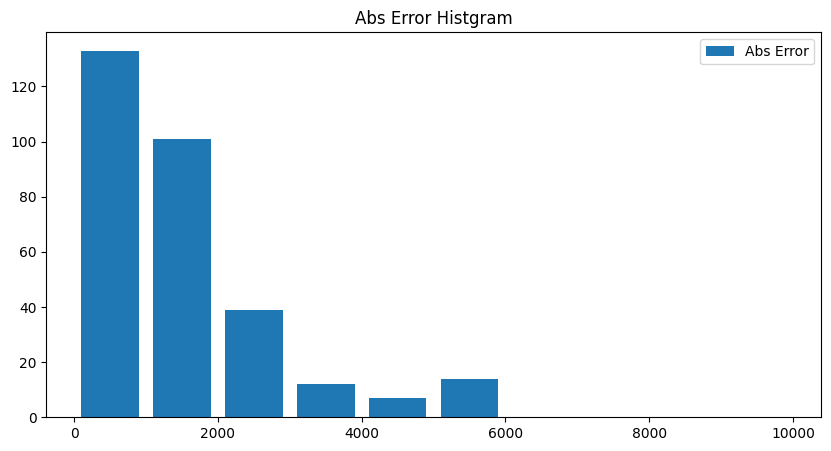

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Abs Error Histgram')
n, bins, patches = plt.hist(df_week3_val3['Abs Error']['2023/08/01':], range=(0, 10000), bins=10, label='Abs Error', rwidth=0.8)
plt.legend()
plt.show()
plt.close()

0~1000 :	 133
1000~2000 :	 101
2000~3000 :	 39
3000~4000 :	 12
4000~5000 :	 7
5000~6000 :	 14
6000~7000 :	 0
7000~8000 :	 0
8000~9000 :	 0
9000~10000 :	 0


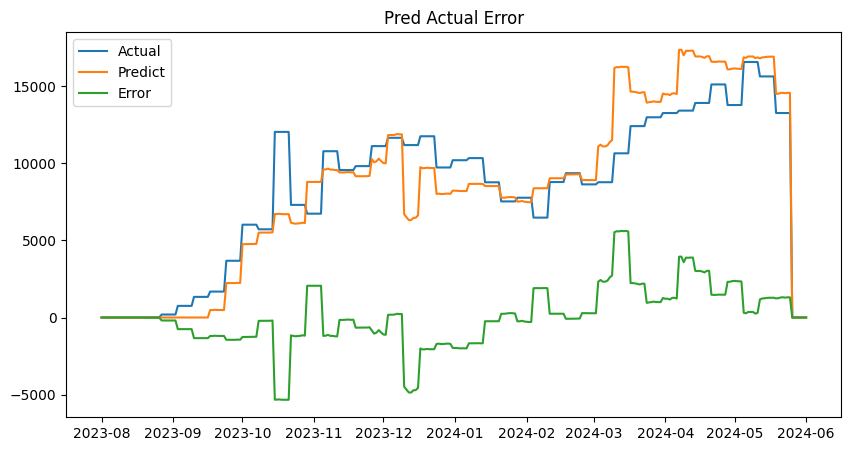

In [ ]:
for i in range(len(n)):
    print(str(int(bins[i]))+'~'+str(int(bins[i+1])), ':\t', int(n[i]))
plt.figure(figsize=(10, 5))
plt.title('Pred Actual Error')
plt.plot(df_week3_val3['Ans']['2023/08/01':], label='Actual')
plt.plot(df_week3_val3['Pred']['2023/08/01':], label='Predict')
plt.plot(df_week3_val3['Error']['2023/08/01':], label='Error')
plt.legend()
plt.show()
plt.close()

In [ ]:
# 評価指標を計算（Abs Errorが0の行を除いて計算）
val_max_error3 = df_week3_val3[df_week3_val3['Abs Error'] != 0]['Abs Error']['2023/08/01':].max()
val_max_error3_day = df_week3_val3[df_week3_val3['Abs Error'] != 0]['Abs Error']['2023/08/01':].idxmax().date().isoformat()
val_max_error_rate3 = df_week3_val3[(df_week3_val3['Abs Error'] != 0) & (df_week3_val3['Abs Error Rate'] < 1)]['Abs Error Rate']['2023/08/01':].max()
val_max_error_rate3_day = df_week3_val3[(df_week3_val3['Abs Error'] != 0) & (df_week3_val3['Abs Error Rate'] < 1)]['Abs Error Rate']['2023/08/01':].idxmax().date().isoformat()
val_min_error3 = df_week3_val3[df_week3_val3['Abs Error'] != 0]['Abs Error']['2023/08/01':].min()
val_mean_abs_error3 = df_week3_val3[df_week3_val3['Abs Error'] != 0]['Abs Error']['2023/08/01':].mean() 
val_mean_abs_error_rate3 = df_week3_val3[df_week3_val3['Abs Error'] != 0]['Abs Error Rate']['2023/08/01':].mean()
val_under_error1000_num3 = str(len(df_week3_val3[df_week3_val3['Abs Error'] < 1000]['Abs Error']['2023/08/01':])) + '/' + str(len(df_week3_val3['2023/08/01':]))
val_up_date3 = len(df_week3_val3[df_week3_val3['Error'] > 0]['2023/08/01':])
val_down_date3 = len(df_week3_val3[df_week3_val3['Error'] < 0]['2023/08/01':])

print('平均誤差率:', val_mean_abs_error_rate3)
print('平均誤差:', val_mean_abs_error3)  
print('最大誤差率:', val_max_error_rate3)
print('最大誤差:', val_max_error3)
print('最小誤差:', val_min_error3)
print('最大誤差率日:', val_max_error_rate3_day)
print('最大誤差日:', val_max_error3_day)
print('1000以下の日数:', val_under_error1000_num3)
print(f'誤差が上振れた日数:{val_up_date3}/{len(df_week3_val3["2023/08/01":])}')
print(f'誤差が下振れた日数:{val_down_date3}/{len(df_week3_val3["2023/08/01":])}')

平均誤差率: 0.2565178842852545
平均誤差: 1488.1228345278719
最大誤差率: 0.7130697394782793
最大誤差: 5618.327717139178
最小誤差: 15.333333334715867
最大誤差率日: 2023-09-18
最大誤差日: 2024-03-13
1000以下の日数: 133/306
誤差が上振れた日数:126/306
誤差が下振れた日数:154/306
